In [1]:
from segment_anything import sam_model_registry
import torch.nn as nn
import torch
import argparse
import os
from utils import FocalDiceloss_IoULoss, generate_point, save_masks
from torch.utils.data import DataLoader
from DataLoader import TestingDataset
from metrics import SegMetrics
import time
from tqdm import tqdm
import numpy as np
from torch.nn import functional as F
import logging
import datetime
import cv2
import random
import csv
import json
import glob


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--work_dir", type=str, default="/root/autodl-tmp/checkpoint/SAM_Med2D_mona_mask1", help="work dir")
    parser.add_argument("--run_name", type=str, default="sam-cryo", help="run model name")
    parser.add_argument("--batch_size", type=int, default=1, help="batch size")
    parser.add_argument("--image_size", type=int, default=1024, help="image_size")
    parser.add_argument('--device', type=str, default='cuda')
    
    # parser.add_argument("--data_path", type=str, default="data_demo", help="train data path") 
    # parser.add_argument("--prompt_path", type=str, default=None, help="fix prompt path")
    
    # parser.add_argument("--test_dataset_path", type=str, default="/root/autodl-tmp/datasets/test_dataset/10017/images/*.jpg", help="test data path")
    # parser.add_argument("--test_point_path", type=str, default="/root/autodl-tmp/result/", help="test data path")
    # SFS使用去噪后的dataset，大小是1024x1024,一个通道
    parser.add_argument("--test_dataset_path", type=str, default="/root/autodl-tmp/datasets/test_dataset/*/denoised/*.jpg", help="test data path")
    parser.add_argument("--test_point_path", type=str, default="/root/autodl-tmp/datasets/test_dataset/*/points2/", help="test data path")
    
    parser.add_argument("--metrics", nargs='+', default=['iou', 'dice'], help="metrics")
    parser.add_argument("--model_type", type=str, default="vit_b", help="sam model_type")
    
    
    parser.add_argument("--sam_checkpoint", type=str, default="/root/autodl-tmp/checkpoint/SAM_Med2D_mona_mask1/models/sam_best.pth", help="sam checkpoint")
    
    parser.add_argument("--boxes_prompt", type=bool, default=False, help="use boxes prompt")
    
    parser.add_argument("--point_num", type=int, default=1, help="point num")
    parser.add_argument("--iter_point", type=int, default=1, help="iter num") 
    parser.add_argument("--multimask", type=bool, default=True, help="ouput multimask")
    parser.add_argument("--encoder_adapter", type=bool, default=True, help="use adapter")
    
    
    parser.add_argument("--save_pred", type=bool, default=True, help="save reslut")
    args = parser.parse_args(args=[])
    if args.iter_point > 1:
        args.point_num = 1
    return args

/root/miniconda3/envs/cryosegnet/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/root/miniconda3/envs/cryosegnet/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.7 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
args = parse_args()
test_image_path = list(glob.glob(args.test_dataset_path))
test_dataset = TestingDataset(args, test_image_path, image_size=args.image_size, mode='test', requires_name=True, point_num=args.point_num, return_ori_mask=True, prompt_path=args.test_point_path)

In [3]:
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=4)
for i, batched_image in enumerate(tqdm(test_loader)):
        print(batched_image["image"].shape, batched_image["label"].shape)
        print(batched_image["point_coords"].shape)
        print(batched_image["point_labels"].shape)
        break
        
  

  0%|          | 0/1855 [00:00<?, ?it/s]

torch.Size([1, 3, 1024, 1024]) torch.Size([1, 1, 1024, 1024])
torch.Size([1, 392, 2])
torch.Size([1, 392])


  0%|          | 0/1855 [00:01<?, ?it/s]


In [4]:
value=test_dataset[100]
print(value['image'].shape)
print(value['label'].shape)
print(value['pro_mask'].shape)
print(value['point_coords'].shape)
print(value['point_labels'].shape)
print(value["original_size"])
print(value['label_path'])
print(value['ori_label'].shape)
print(value['name'])

torch.Size([3, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([112, 2])
torch.Size([112])
(4096, 4096)
/root/autodl-tmp/datasets/test_dataset/10028/masks
torch.Size([1, 4096, 4096])
/root/autodl-tmp/datasets/test_dataset/10028/denoised/077.jpg


In [4]:
print(value['point_coords'])

tensor([[676.4105,  43.5931],
        [964.2200,  48.6240],
        [147.1169,  75.6855],
        [490.7215,  76.5754],
        [726.4502,  77.3977],
        [827.6840,  74.4367],
        [903.9401,  75.3201],
        [ 69.4776,  88.7954],
        [345.4388, 119.3861],
        [591.0456, 117.6544],
        [934.8228, 115.3597],
        [136.3210, 141.8546],
        [793.6467, 137.9642],
        [551.3714, 144.3696],
        [689.6159, 150.5475],
        [640.3215, 160.3238],
        [ 78.5572, 190.0660],
        [222.5230, 178.4016],
        [796.2687, 187.8448],
        [847.5818, 177.0977],
        [987.6256, 180.7878],
        [358.0806, 204.9994],
        [ 38.5568, 216.3118],
        [475.4150, 217.2076],
        [518.6605, 237.5197],
        [597.0385, 241.5826],
        [206.3061, 266.5227],
        [456.4054, 264.5446],
        [673.7107, 289.5905],
        [108.9660, 310.5706],
        [159.9575, 310.8694],
        [795.4248, 315.8965],
        [268.5372, 324.1977],
        [4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


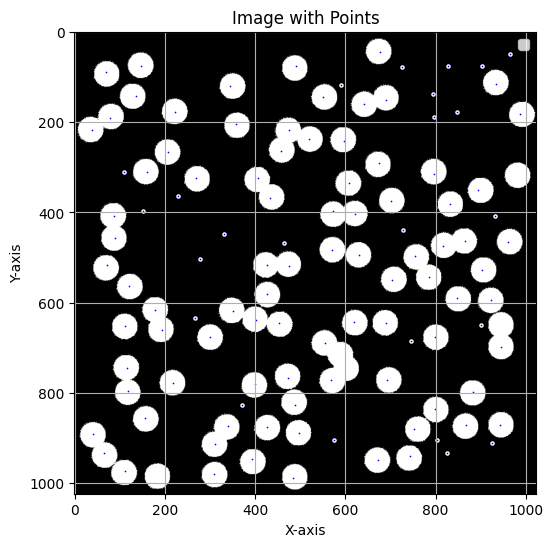

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np

image = value['label']
image_np = image.numpy()[0]


# 绘制图像
plt.figure(figsize=(6, 6))
plt.imshow(image_np, cmap='gray')

points=value["point_coords"]
# 标注点
x = [point[0] for point in points]
y = [point[1] for point in points]
plt.scatter(x, y, c='blue', s=5, edgecolor='white')  # 红色点，带白色边框以增强可见性
plt.title("Image with Points")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


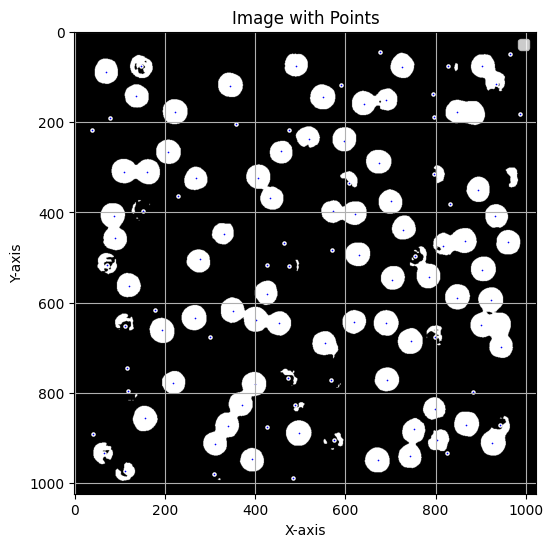

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np

image = value['pro_mask']
image_np = image.numpy()[0]


# 绘制图像
plt.figure(figsize=(6, 6))
plt.imshow(image_np, cmap='gray')

points=value["point_coords"]
# 标注点
x = [point[0] for point in points]
y = [point[1] for point in points]
plt.scatter(x, y, c='blue', s=5, edgecolor='white')  # 红色点，带白色边框以增强可见性
plt.title("Image with Points")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


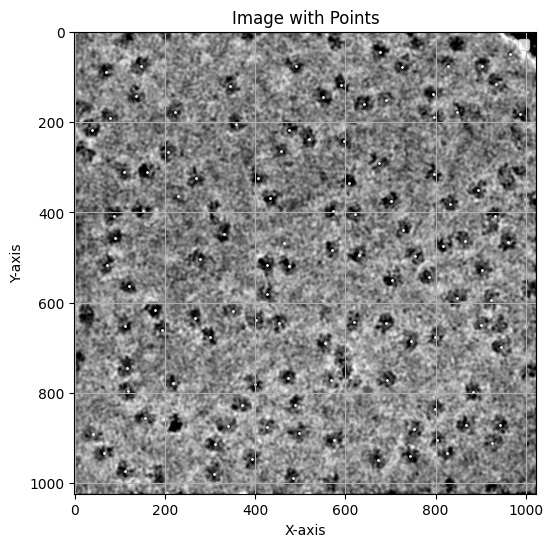

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np

image = value['image']
gray_image = image[0,  :, :]
image_np = gray_image.numpy()

# 绘制图像
plt.figure(figsize=(6, 6))
plt.imshow(image_np, cmap='gray')


points=value["point_coords"]
# # 标注点
x_coords = [point[0] for point in points]
y_coords = [point[1] for point in points]
plt.scatter(x_coords, y_coords, c='red', s=1, edgecolor='white')  # 红色点，带白色边框以增强可见性

# points_all=vuale[-1]
# # # 标注点
# x = [point[0] for point in points_all]
# y = [point[1] for point in points_all]
# plt.scatter(x, y, c='blue', s=5, edgecolor='white')  # 红色点，带白色边框以增强可见性


plt.title("Image with Points")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid(True)
plt.show()

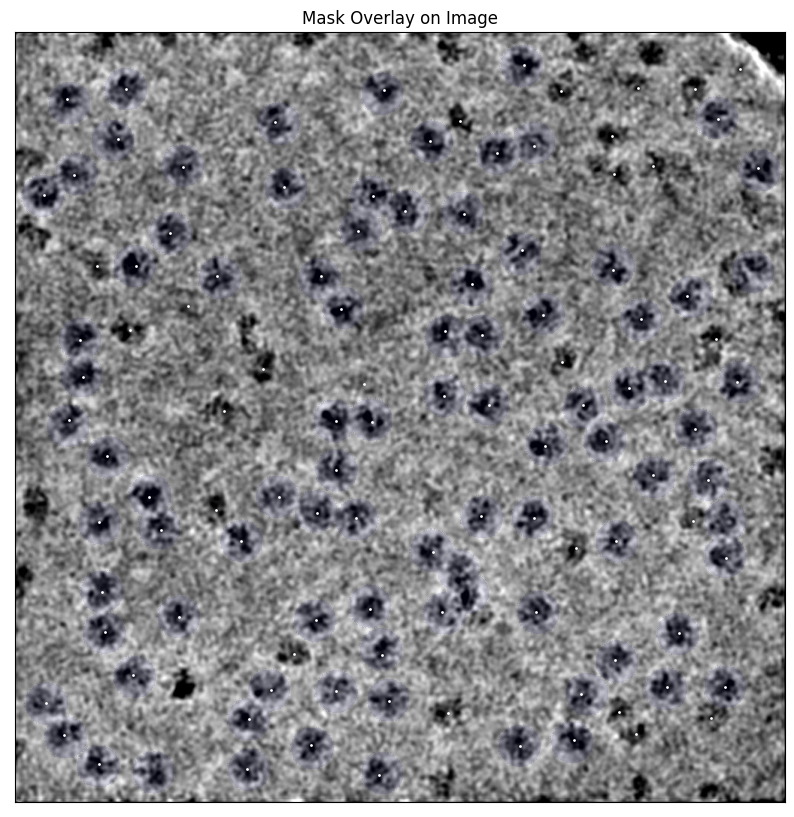

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 假设 v 是包含数据的变量
image = value['image']  # (1, 1024, 1024)
mask = value['label'][0]
points = value['point_coords'] # 关键点坐标

# 获取灰度图像
gray_image = image[0, :, :].numpy()  # 转换为 numpy 数组

# # 计算合并的 mask
# combined_mask = mask.sum(dim=0).clamp(0, 25).numpy()  # 叠加并转换为 numpy

# 提取关键点坐标
x_coords = [point[0] for point in points]
y_coords = [point[1] for point in points]

# 绘制图像
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(gray_image, cmap='gray')  # 原始图像
masked_mask = np.ma.masked_where(mask == 0, mask)
ax.imshow(masked_mask, cmap='jet', alpha=0.1, interpolation='nearest')  # 透明叠加

# 标注关键点
ax.scatter(x_coords, y_coords, c='red', s=1, edgecolors='white')

ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Mask Overlay on Image")

# 添加颜色条，仅对 `masked_mask` 生效
# cbar = plt.colorbar(ax.imshow(masked_mask, cmap='jet', alpha=0.5), ax=ax)
# cbar.set_label("Mask Overlap Count")

plt.show()


In [1]:
import os

# 指定文件夹路径
folder_path = "/root/autodl-tmp/datasets/test_dataset/10017/denoised/"

# 获取文件列表
file_list = os.listdir(folder_path)

# 统计文件数量
num_files = len(file_list)

print(f"Total files: {num_files}")


Total files: 67


In [7]:
import os

# 指定文件夹路径
folder_a = "/root/autodl-tmp/sfs_result/11056/masks"  # 替换为你的文件夹 A 路径
folder_b = "/root/autodl-tmp/sfs_result/11056/denoised"  # 替换为你的文件夹 B 路径

# 获取文件名列表（仅文件名，不含路径）
files_a = {f for f in os.listdir(folder_a) if os.path.isfile(os.path.join(folder_a, f))}
files_b = {f for f in os.listdir(folder_b) if os.path.isfile(os.path.join(folder_b, f))}
# 去掉 A 中文件名的 "_mask" 后缀
files_a_no_mask = {f.replace("_mask", "") for f in files_a}

# 找出只在 A（带 _mask 版本）但去掉 _mask 后不在 B 的文件
only_in_a = {f for f in files_a if f.replace("_mask", "") not in files_b}

# 找出只在 B 但不在 A（_mask 版本）的文件
only_in_b = {f for f in files_b if f not in files_a_no_mask}

print("Files only in A (with _mask):", only_in_a)
print("Files only in B:", only_in_b)


Files only in A (with _mask): set()
Files only in B: set()
